# Natural Computing - Project - Data Preprocessing 
#### Group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

## Imports

In [1]:
# Data processing and plotting
from tensorflow.keras.datasets import mnist, fashion_mnist
from skimage.transform import resize
import matplotlib.pyplot as plt

# Standard python imports
import numpy as np
import pickle, os

# Magic for inline plots
%matplotlib inline

## Global parameters

In [2]:
# Dataset parameters
DATASET = "MNIST" # choose from {"MNIST", "Fashion-MNIST"}
DESIRED_IMAGE_SIZE = 16
N_CLASSES_TO_USE = 4

# Processing parameters
DO_ANTI_ALIASING = False
DO_NORMALIZATION = True

## Preprocessing data

##### Downloading the correct dataset

In [3]:
# Load the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() if DATASET == "MNIST" else fashion_mnist.load_data()

##### Removing classes

In [4]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

In [5]:
# Extract and print the number of training and testing samples remaining
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 24754
Testing samples remaining: 4157


##### Rescaling

In [6]:
# Rescaling to the desired size
def rescale_images(images, do_anti_aliasing):
    desired_image_shape = (DESIRED_IMAGE_SIZE, DESIRED_IMAGE_SIZE)
    return np.array([resize(image, desired_image_shape, anti_aliasing=do_anti_aliasing) for image in images])

# Rescale X_train and X_test
X_train_small = rescale_images(X_train, DO_ANTI_ALIASING)
X_test_small = rescale_images(X_test, DO_ANTI_ALIASING)

##### Normalization

In [7]:
# Normalize the data
def normalize(images):
    return (images - np.mean(images, axis=0))/(np.std(images, axis=0) + 0.000001)

# Normalize X_train_small and X_test_small, if required
if DO_NORMALIZATION:
    X_train_norm = normalize(X_train_small)
    X_test_norm = normalize(X_test_small)

##### Plotting an example

In [8]:
# Function for plotting an image before and after processing, side-by-side
def plot_comparison(idx_to_plot, datasets, titles):
    n_plots = len(datasets)
    fig, ax = plt.subplots(1,n_plots, figsize=(10,10/n_plots))
    for i in range(n_plots):
        ax[i].imshow(datasets[i][idx_to_plot])
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    fig.suptitle(f"Preprocessing of sample {idx_to_plot}",y=1)
    plt.show()

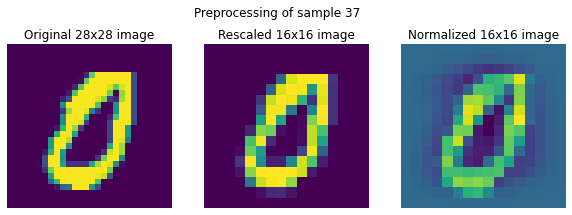

In [9]:
# Plot an example image
idx_to_plot = 37
datasets = [X_train, X_train_small] + ([X_train_norm] if DO_NORMALIZATION else [])
titles = [f"Original {X_train.shape[1]}x{X_train.shape[1]} image",
          f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image",
          f"Normalized {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image"]
plot_comparison(idx_to_plot, datasets, titles)

##### Wrapping up

In [10]:
# Replace and reshape X_train and X_test, for convenience
X_train = (X_train_norm if DO_NORMALIZATION else X_train_small).reshape(n_samples_train, DESIRED_IMAGE_SIZE**2)
X_test = (X_test_norm if DO_NORMALIZATION else X_test_small).reshape(n_samples_test, DESIRED_IMAGE_SIZE**2)

In [11]:
# Check if data folder exists; if not, create it
if not os.path.exists("data"):
    os.mkdir("data")
    
# Set the correct filename
filename = f"{DATASET}-{N_CLASSES_TO_USE}{'-Norm' if DO_NORMALIZATION else ''}{'-AA' if DO_ANTI_ALIASING else ''}.pkl"

# Store the preprocessed data
with open(os.path.join("data", filename), "wb") as f:
    pickle.dump(((X_train, Y_train), (X_test, Y_test)), f)